In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

comment = "Swarm observations with tapered ensemble as prior"
nb_name = "nb_case_core_vires_swarm_obs"

In [2]:
C_e_const = 2.0
shc_g = 30
shc_grid = 30

# Load core object
file_pickle = open("{}.obj".format(nb_name), 'rb')
core = pickle.load(file_pickle)
file_pickle.close()
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = False)
core.generate_map()

# Swarm obs
import datetime as dt
from viresclient import SwarmRequest
request = SwarmRequest()
collect = "SW_OPER_MAGA_LR_1B"
use_meas = ["B_NEC"]
use_aux = ["SunZenithAngle", "Kp", "QDLat", "Dst", "IMF_BZ_GSM"]
use_models = ["M_use = 'LCS-1' + 'CHAOS-MMA-Primary' + 'CHAOS-MMA-Secondary' + 'MIO_SHA_2C'"] #'CHAOS-Core' + 
request.set_collection(collect)
request.set_products(measurements=use_meas,
                     models = use_models,
                     auxiliaries=use_aux,
                     residuals=False,
                     sampling_step="PT5M")

data = request.get_between(start_time=dt.datetime(2019,7,1),
                           end_time=dt.datetime(2019,12,1))
ds = data.as_xarray()
SZA_angle = 115
Kp_max = 2
dDst_dt_max = 2
Dst_abs_max = 30
QDlat_max = 90
IMF_BZ_min = 0.0
dDst_dt = (abs(np.diff(ds.Dst.values,prepend=0))/5)*60 #(nT/5min)/5 * 60min/hr -> nT/hr
Dst_abs = abs(ds.Dst.values)
idx_sort = np.logical_and.reduce((np.abs(ds.SunZenithAngle.values)>SZA_angle, 
                                  ds.Kp.values<=Kp_max, abs(ds.QDLat.values)<QDlat_max, 
                                  dDst_dt<=dDst_dt_max, Dst_abs < Dst_abs_max,
                                  ds.IMF_BZ_GSM>IMF_BZ_min))
obs_sat = SDSS(comment, N_SH = shc_g)
obs_sat.data = -ds["B_NEC"].values[:,2][idx_sort] + ds["B_NEC_M_use"].values[:,2][idx_sort] 
obs_sat.r_grid = ds.Radius[idx_sort].values/10**3
obs_sat.lon = ds.Longitude[idx_sort].values
obs_sat.lat = ds.Latitude[idx_sort].values
obs_sat.grid_N = len(obs_sat.data)
print(obs_sat.grid_N)

[1/1] Processing:  100%|██████████|  [ Elapsed: 01:27, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (5.453MB)


2853


<IPython.core.display.Javascript object>


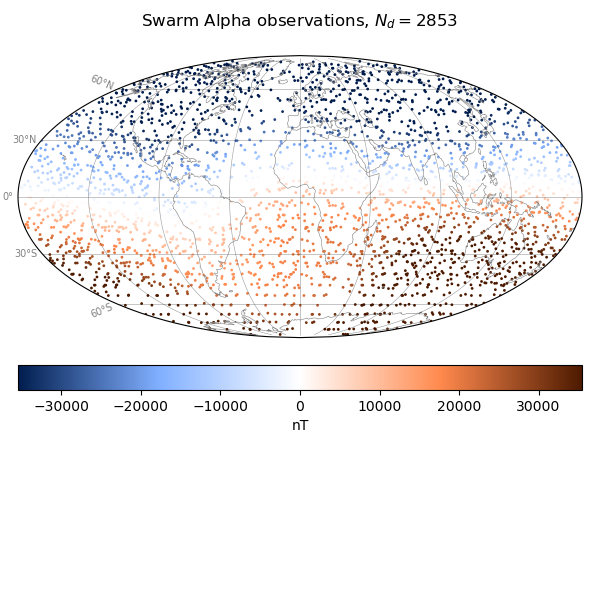

<IPython.core.display.Javascript object>


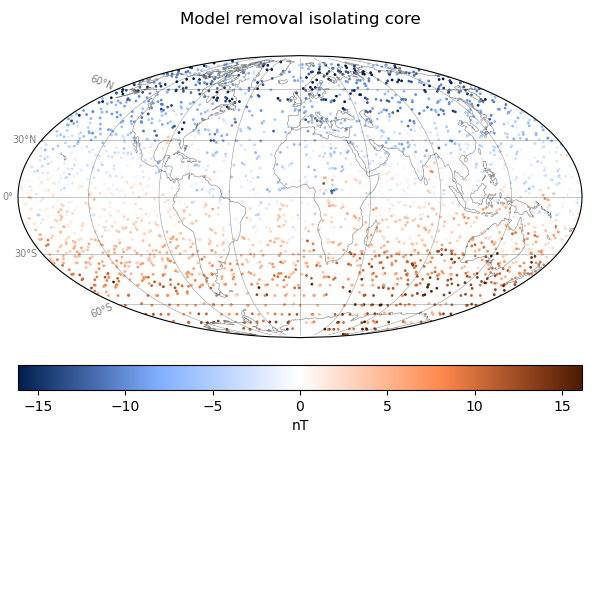

In [12]:
mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=obs_sat.data, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Swarm Alpha observations, $N_d={}$'.format(obs_sat.grid_N), point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_core_vires_swarm_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=-ds["B_NEC_M_use"].values[:,2][idx_sort], 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Model removal isolating core', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

<IPython.core.display.Javascript object>


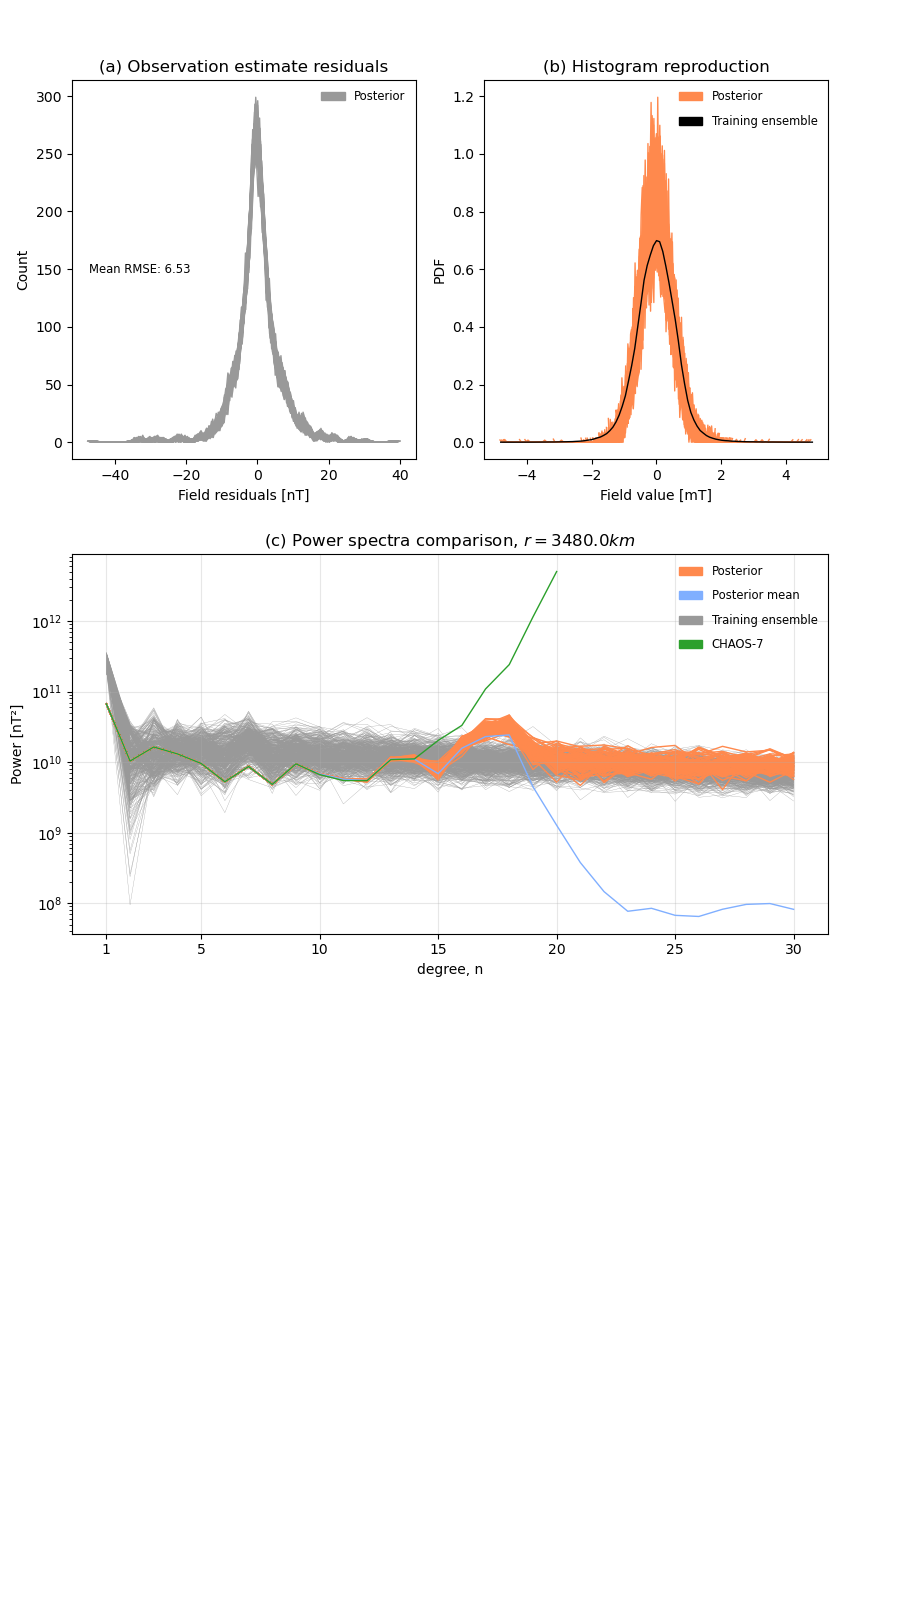

In [27]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = None, truth_obj = None,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              spec_ti_ens = True, spec_lwidth = 1.0, label_fontsize = "small",
                              model_dict = {"CHAOS-7"}, spec_chaos_time = [2019,9,1],
                              res_use = True, sv_use = False, unit_field = "[mT]", unit_res = "[nT]",
                              unit_transform_n_to_m = True, patch_legend = True,
                              figsize=(9,16), hist_ti_ens = True, hist_density = True,
                              hist_bins = 101, res_bins = 101, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "case_core_vires_swarm_obs", save_dpi = 300,
                              save_path = "images/")

In [23]:
#core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)
core.grid_glq(nmax = 400, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


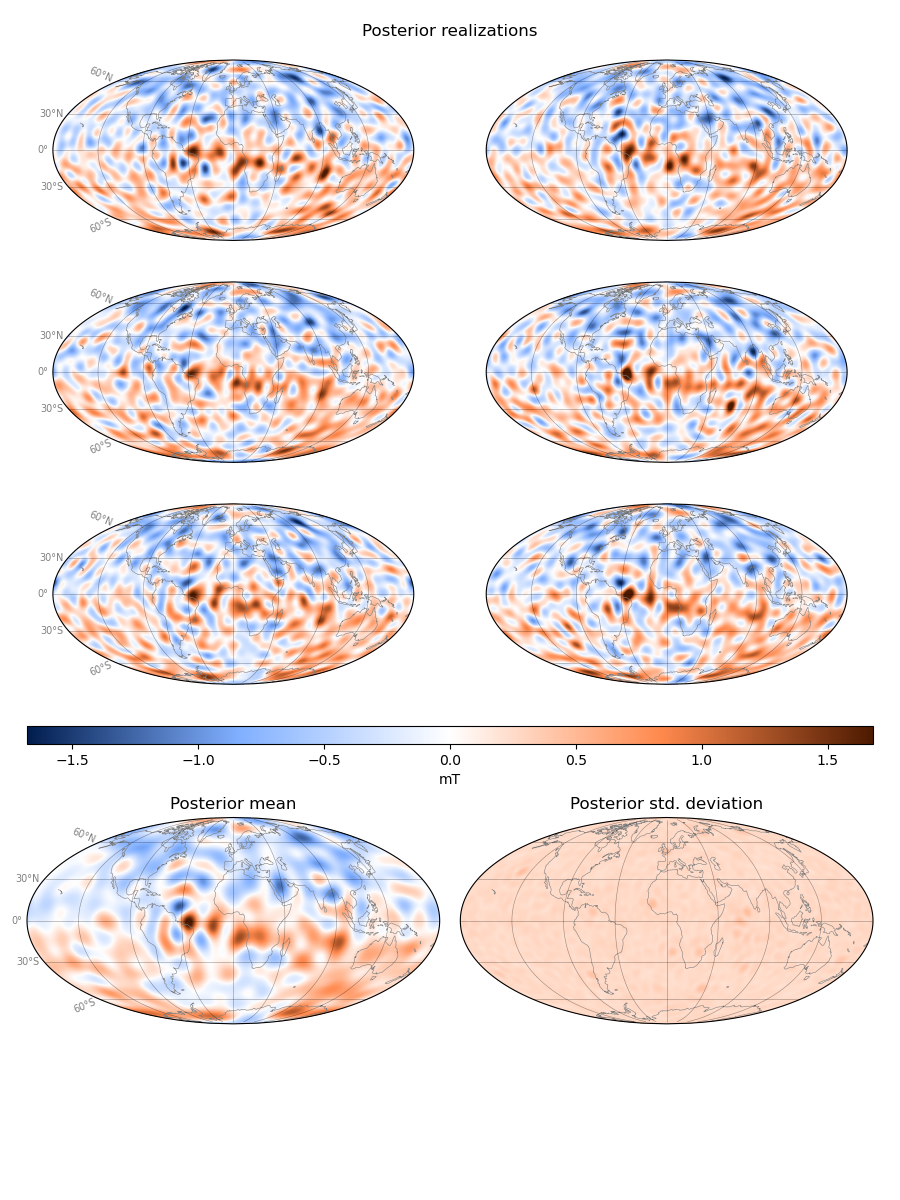

In [25]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = None, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 4, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 2/5,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "case_core_vires_swarm_obs", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100, save_path = "images/")
